# Lab 3: Why Does My Model Break? 🔍

**Computer Vision Course**

---

> *"A model that only works in perfect conditions is not a real model."*

In Lab 2 you trained a neural network on MNIST and hit ~97% accuracy. Impressive!

But here is a question worth sitting with: **what happens to that accuracy when the images are not perfect?**

Real-world images are never perfect. Cameras over-expose. Scans get rotated. Photos are blurry. Lenses add noise. Today you will discover, by experiment, exactly how fragile your model is — and begin to understand why.

**This lab has two connected parts:**

| Part | Activity | Purpose |
|------|----------|---------|
| **Part 1** | Image Transformations as "Filters" | *See* how images can vary |
| **Part 2** | MNIST Stress Test | *Measure* what that variation does to your model |

By the end you will have answered this question yourself:

> *Why do neural networks fail on images they have never seen before?*

## Setup

In [55]:
import os, sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    if not os.path.exists('computer-vision'):
        !git clone https://github.com/mjck/computer-vision.git
    %cd computer-vision/labs/lab03_robustness
    sys.path.insert(0, '/content/computer-vision')
else:
    repo_root = os.path.abspath('../..')
    if repo_root not in sys.path:
        sys.path.insert(0, repo_root)

print("✅ Setup complete")

✅ Setup complete


## Imports

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import rotate as scipy_rotate
from tqdm import tqdm

try:
    from sdx import *
    print("✓ sdx module loaded")
except ImportError as e:
    print(f"❌ Could not import sdx: {e}")
    raise

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Device: {device}")

✓ sdx module loaded
✓ Device: cpu


---
## Part 1 — Image Transformations 🎨

Before we stress-test our model, let us first build intuition.

In this part you will apply four transformations to a set of images. Each transformation represents something that commonly happens to images in the real world:

| Transformation | Real-world cause |
|---------------|-----------------|
| **Brightness** | Over/under exposure, bad lighting |
| **Noise** | Sensor noise, low-quality camera |
| **Blur** | Camera shake, out of focus |
| **Rotation** | Tilted camera, different viewing angle |

Look at the results carefully. Ask yourself: *does this still look like the same image to you?* Remember that answer when you see what it does to your model.

### Loading Sample Images

We'll use a small selection of MNIST digits as our test images — the same data your model was trained on.

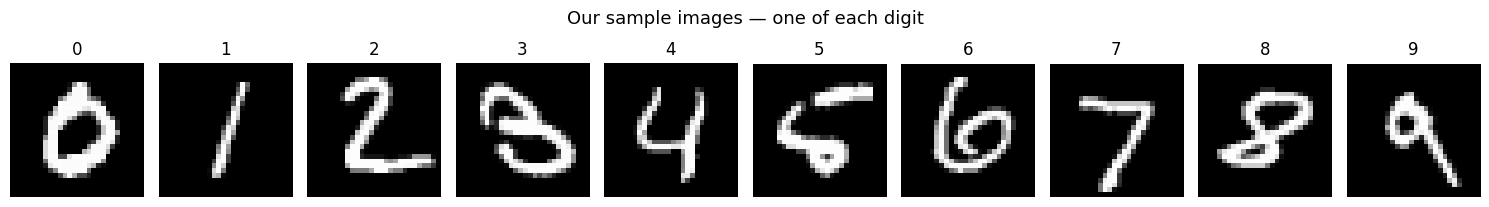

Images are 28×28 pixels, grayscale, values in [0, 1]


In [57]:
# Load MNIST
test_dataset = datasets.MNIST(root='./data', train=False, download=True,
                               transform=transforms.ToTensor())

# Pick one example of each digit 0-9 for visual demos
samples = {}
for img, label in test_dataset:
    if label not in samples:
        samples[label] = img.squeeze().numpy()  # (28, 28)
    if len(samples) == 10:
        break

# Display them
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for digit, ax in enumerate(axes):
    ax.imshow(samples[digit], cmap='gray', vmin=0, vmax=1)
    ax.set_title(str(digit), fontsize=12)
    ax.axis('off')
fig.suptitle("Our sample images — one of each digit", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()
print("Images are 28×28 pixels, grayscale, values in [0, 1]")

### The Four Transformations

Below are four functions that transform an image. Three of them are already implemented.

**Your task:** implement `add_noise()` — it is the simplest one.

In [74]:
# ── Transformation 1: Brightness ──────────────────────────────────────────
def adjust_brightness(image, factor):
    """
    Multiply every pixel by `factor`.
    factor > 1  →  brighter
    factor < 1  →  darker
    Values are clipped to stay in [0, 1].

    Returns: 
        Adjusted image, clipped to [0, 1]
    """
    # ── your code here ──────────────────────────────────────────────────────
    
    res = image * factor
    np.clip(res, 0, 1, out=res)
    return res
    
    # ────────────────────────────────────────────────────────────────────────


# ── Transformation 2: Noise ────────────────────────────────────────────────
def add_noise(image, std):
    """
    Add Gaussian noise to the image.

    Gaussian noise:  each pixel gets a small random value added to it,
    drawn from a normal distribution with mean=0 and standard deviation=std.

    Args:
        image : numpy array, values in [0, 1]
        std   : noise strength (try 0.1, 0.3, 0.5)

    Returns:
        Noisy image, clipped to [0, 1]

    TODO: implement this function.
    """
    # ── your code here ──────────────────────────────────────────────────────

    noisy = image.copy()
    for j in range(len(image)):
        for i in range(len(image[0])):
            noise = np.random.normal(loc=0, scale=std)
            noisy[i][j] += noise
    np.clip(noisy, 0, 1)
    return noisy

    # ────────────────────────────────────────────────────────────────────────


# ── Transformation 3: Blur ─────────────────────────────────────────────────
def apply_blur(image, kernel_size):
    """
    Average each pixel with its neighbours using a square kernel.
    kernel_size=1  →  no change
    kernel_size=5  →  visibly blurry
    kernel_size=11 →  very blurry
    """
    if kernel_size <= 1:
        return image.copy()
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size ** 2)
    from scipy.ndimage import convolve
    return np.clip(convolve(image, kernel), 0, 1)


# ── Transformation 4: Rotation ─────────────────────────────────────────────
def apply_rotation(image, angle_degrees):
    """
    Rotate the image by `angle_degrees` around its centre.
    Pixels that fall outside the frame become 0 (black).
    TODO: implement this function.
    HINT: use scipy.ndimage.rotate
    """

    # ── your code here ──────────────────────────────────────────────────────
    
    rotated = image.copy()
    rotated = scipy_rotate(rotated, angle_degrees, reshape=False)
    return rotated
    
    # ────────────────────────────────────────────────────────────────────────


print("✓ Transformation functions defined")
print()
print("Remember to implement missing functions above before continuing!")

✓ Transformation functions defined

Remember to implement missing functions above before continuing!


### ✏️ Exercise 1 — Test Your `add_noise()` Function

Run the cell below. If your implementation is correct, the digit should look grainy.
If it returns `None` or looks unchanged, go back and fix `add_noise()`.

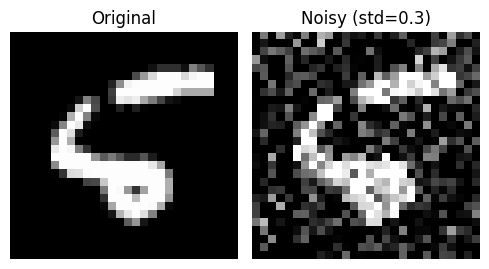

✓ add_noise() works correctly
False


In [75]:
# Test add_noise on the digit "5"
img = samples[5]

noisy = add_noise(img, std=0.3)

if noisy is None:
    print("❌ add_noise() returned None — did you forget the return statement?")
else:
    fig, axes = plt.subplots(1, 2, figsize=(5, 3))
    axes[0].imshow(img,   cmap='gray', vmin=0, vmax=1)
    axes[0].set_title("Original")
    axes[0].axis('off')
    axes[1].imshow(noisy, cmap='gray', vmin=0, vmax=1)
    axes[1].set_title("Noisy (std=0.3)")
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()
    print("✓ add_noise() works correctly")
    print(f"{np.array_equal(img, noisy)}")

### Transformation Gallery

Let's now see all four transformations applied to digits 3, 7 and 9 — three digits that are commonly confused.

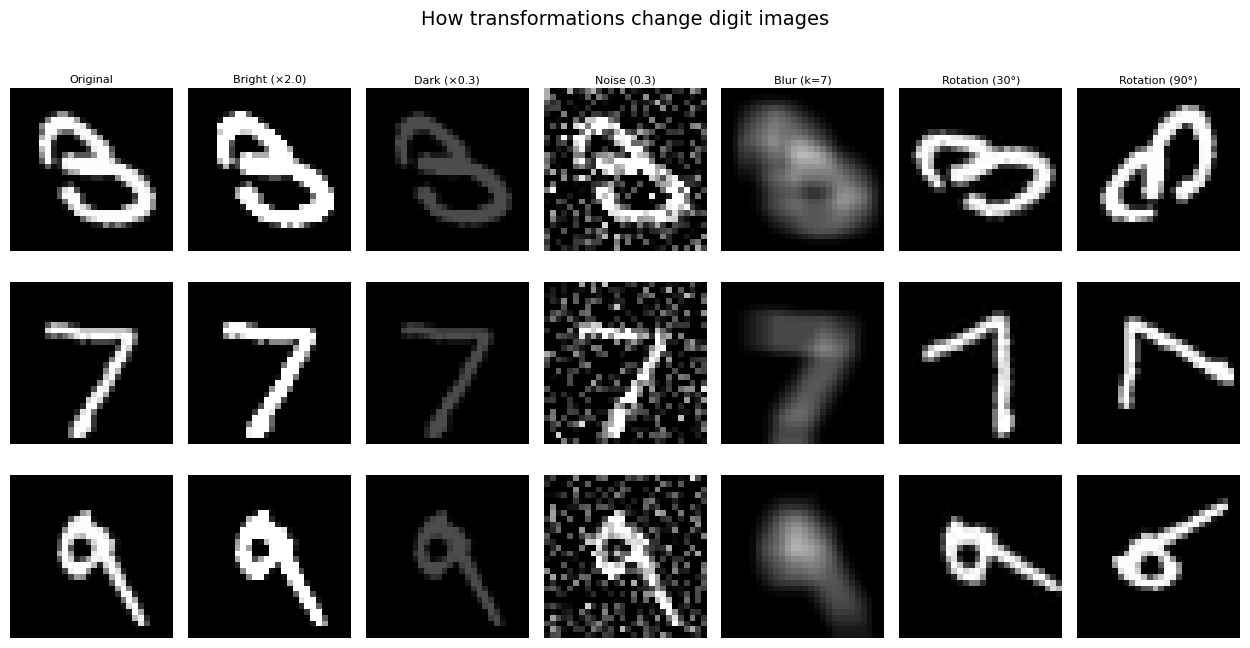

In [76]:
demo_digits = [3, 7, 9]

transformations = [
    ("Original",         lambda img: img),
    ("Bright (×2.0)",    lambda img: adjust_brightness(img, 2.0)),
    ("Dark (×0.3)",      lambda img: adjust_brightness(img, 0.3)),
    ("Noise (0.3)",      lambda img: add_noise(img, std=0.3)),
    ("Blur (k=7)",       lambda img: apply_blur(img, kernel_size=7)),
    ("Rotation (30°)",   lambda img: apply_rotation(img, 30)),
    ("Rotation (90°)",   lambda img: apply_rotation(img, 90)),
]

n_rows = len(demo_digits)
n_cols = len(transformations)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.8, n_rows * 2.2))
fig.suptitle("How transformations change digit images", fontsize=14, y=1.01)

for row, digit in enumerate(demo_digits):
    for col, (label, fn) in enumerate(transformations):
        ax = axes[row][col]
        result = fn(samples[digit])
        ax.imshow(result, cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
        if row == 0:
            ax.set_title(label, fontsize=8, pad=4)
        if col == 0:
            ax.set_ylabel(f"Digit {digit}", fontsize=10)

plt.tight_layout()
plt.show()

### ✏️ Exercise 2 — Look Before You Measure

Before running any model, answer these questions based on what you see in the gallery:

1. Which transformation do you think will **hurt the model most?** Why?
2. Which transformation do you think the model will **handle best?** Why?
3. Is the 90° rotated "7" still recognisable to you as a human?

*(Write your answers as a comment in the cell below. We will revisit them after Part 2.)*

In [61]:
# Your predictions (answer all three questions):

# 1. The transformation that will hurt the model most:
#    Rotation (or blur), because the kernels will not detect the right features, makinng it hard to guess the numbers

# 2. The transformation the model will handle best:
#    Brightness, because it doesnt change the intermeiary features

# 3. Is the 90°-rotated "7" still recognisable to you?
#    Yes


---
## Part 2 — The MNIST Stress Test 🧪

Time to measure what those transformations actually do to a neural network.

### Plan
1. Train a model on **clean MNIST** (same as Lab 2)
2. Evaluate it on **transformed MNIST** — same images, different conditions
3. Plot the accuracy vs. transformation strength
4. Compare results to your predictions from Exercise 2

### The Model

We use the same architecture from Lab 2 — a simple network with one hidden layer and ReLU. No changes.

In [77]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1  = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2  = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc2(self.relu(self.fc1(x)))


model     = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_params = sum(p.numel() for p in model.parameters())
print(f"Model: SimpleNN  |  Parameters: {n_params:,}  |  Device: {device}")

Model: SimpleNN  |  Parameters: 101,770  |  Device: cpu


### Train on Clean MNIST

We train on **unmodified** MNIST for 3 epochs — long enough to reach ~97%.

In [78]:
train_dataset = datasets.MNIST(root='./data', train=True,  download=True,
                               transform=transforms.ToTensor())
test_dataset  = datasets.MNIST(root='./data', train=False, download=True,
                               transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False)

def train(model, loader, criterion, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        total, correct, running_loss = 0, 0, 0.0
        bar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, labels in bar:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            out  = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            preds    = out.argmax(1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
            bar.set_postfix(loss=f"{running_loss/(bar.n+1):.3f}",
                            acc=f"{100*correct/total:.1f}%")
    print(f"\n✓ Training complete")

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds    = model(imgs).argmax(1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    return 100 * correct / total

train(model, train_loader, criterion, optimizer, epochs=3)
clean_accuracy = evaluate(model, test_loader)
print(f"\n📊 Accuracy on clean test set: {clean_accuracy:.2f}%")
print("This is our baseline — the best we can do.")

Epoch 3/3: 100%|██████████| 938/938 [00:02<00:00, 400.13it/s, acc=96.8%, loss=0.114]



✓ Training complete

📊 Accuracy on clean test set: 96.93%
This is our baseline — the best we can do.


### The Stress Test

Now the key experiment.

For each transformation, we will:
1. Apply it at **several increasing strengths** to the entire test set
2. Evaluate the model on each modified version
3. Record how accuracy changes

The model sees images it has **never encountered in training** — just like in the real world.

In [79]:
def evaluate_with_transform(model, dataset, transform_fn, batch_size=256):
    """
    Apply transform_fn to every image in dataset, then evaluate the model.
    transform_fn receives a (28,28) numpy array, returns a (28,28) numpy array.
    """
    model.eval()
    correct, total = 0, 0

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for imgs, labels in loader:
            # imgs: (B, 1, 28, 28) tensor in [0,1]
            imgs_np = imgs.squeeze(1).numpy()  # → (B, 28, 28)

            # Apply transform to each image in the batch
            transformed = np.stack([transform_fn(img) for img in imgs_np])

            # Back to tensor
            t = torch.FloatTensor(transformed).unsqueeze(1).to(device)
            l = labels.to(device)

            preds    = model(t).argmax(1)
            correct += (preds == l).sum().item()
            total   += l.size(0)

    return 100 * correct / total


print("✓ evaluate_with_transform() ready")

✓ evaluate_with_transform() ready


### Running All Experiments

This will take 1-2 minutes. Watch the numbers as they appear — you may be surprised.

In [80]:
results = {}

# ── Brightness sweep ───────────────────────────────────────────────────────
print("Testing brightness...")
brightness_factors = [0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0]
results['brightness'] = {
    'x'      : brightness_factors,
    'xlabel' : 'Brightness factor (1.0 = original)',
    'acc'    : []
}
for f in brightness_factors:
    acc = evaluate_with_transform(model, test_dataset,
                                  lambda img, f=f: adjust_brightness(img, f))
    results['brightness']['acc'].append(acc)
    print(f"  factor={f:.1f}  →  {acc:.1f}%")

# ── Noise sweep ────────────────────────────────────────────────────────────
print("\nTesting noise...")
noise_stds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0]
results['noise'] = {
    'x'      : noise_stds,
    'xlabel' : 'Noise standard deviation (0 = no noise)',
    'acc'    : []
}
for s in noise_stds:
    acc = evaluate_with_transform(model, test_dataset,
                                  lambda img, s=s: add_noise(img, s) if s > 0 else img)
    results['noise']['acc'].append(acc)
    print(f"  std={s:.1f}  →  {acc:.1f}%")

# ── Blur sweep ─────────────────────────────────────────────────────────────
print("\nTesting blur...")
kernel_sizes = [1, 3, 5, 7, 9, 11, 15]
results['blur'] = {
    'x'      : kernel_sizes,
    'xlabel' : 'Blur kernel size (1 = no blur)',
    'acc'    : []
}
for k in kernel_sizes:
    acc = evaluate_with_transform(model, test_dataset,
                                  lambda img, k=k: apply_blur(img, k))
    results['blur']['acc'].append(acc)
    print(f"  kernel={k}  →  {acc:.1f}%")

# ── Rotation sweep ─────────────────────────────────────────────────────────
print("\nTesting rotation...")
angles = [0, 5, 10, 15, 20, 30, 45, 60, 90]
results['rotation'] = {
    'x'      : angles,
    'xlabel' : 'Rotation angle (degrees)',
    'acc'    : []
}
for a in angles:
    acc = evaluate_with_transform(model, test_dataset,
                                  lambda img, a=a: apply_rotation(img, a))
    results['rotation']['acc'].append(acc)
    print(f"  angle={a}°  →  {acc:.1f}%")

print("\n✅ All experiments complete!")

Testing brightness...
  factor=0.1  →  81.2%
  factor=0.3  →  96.5%
  factor=0.5  →  97.0%
  factor=0.7  →  97.0%
  factor=1.0  →  96.9%
  factor=1.5  →  96.7%
  factor=2.0  →  96.3%
  factor=3.0  →  96.1%

Testing noise...
  std=0.0  →  96.9%
  std=0.1  →  96.5%
  std=0.2  →  94.8%
  std=0.3  →  90.8%
  std=0.4  →  85.1%
  std=0.5  →  77.4%
  std=0.7  →  64.8%
  std=1.0  →  47.3%

Testing blur...
  kernel=1  →  96.9%
  kernel=3  →  96.4%
  kernel=5  →  92.7%
  kernel=7  →  70.7%
  kernel=9  →  43.3%
  kernel=11  →  27.7%
  kernel=15  →  14.6%

Testing rotation...
  angle=0°  →  96.9%
  angle=5°  →  96.6%
  angle=10°  →  95.2%
  angle=15°  →  92.6%
  angle=20°  →  87.7%
  angle=30°  →  70.9%
  angle=45°  →  41.6%
  angle=60°  →  22.9%
  angle=90°  →  14.0%

✅ All experiments complete!


### Results — Accuracy vs. Transformation Strength

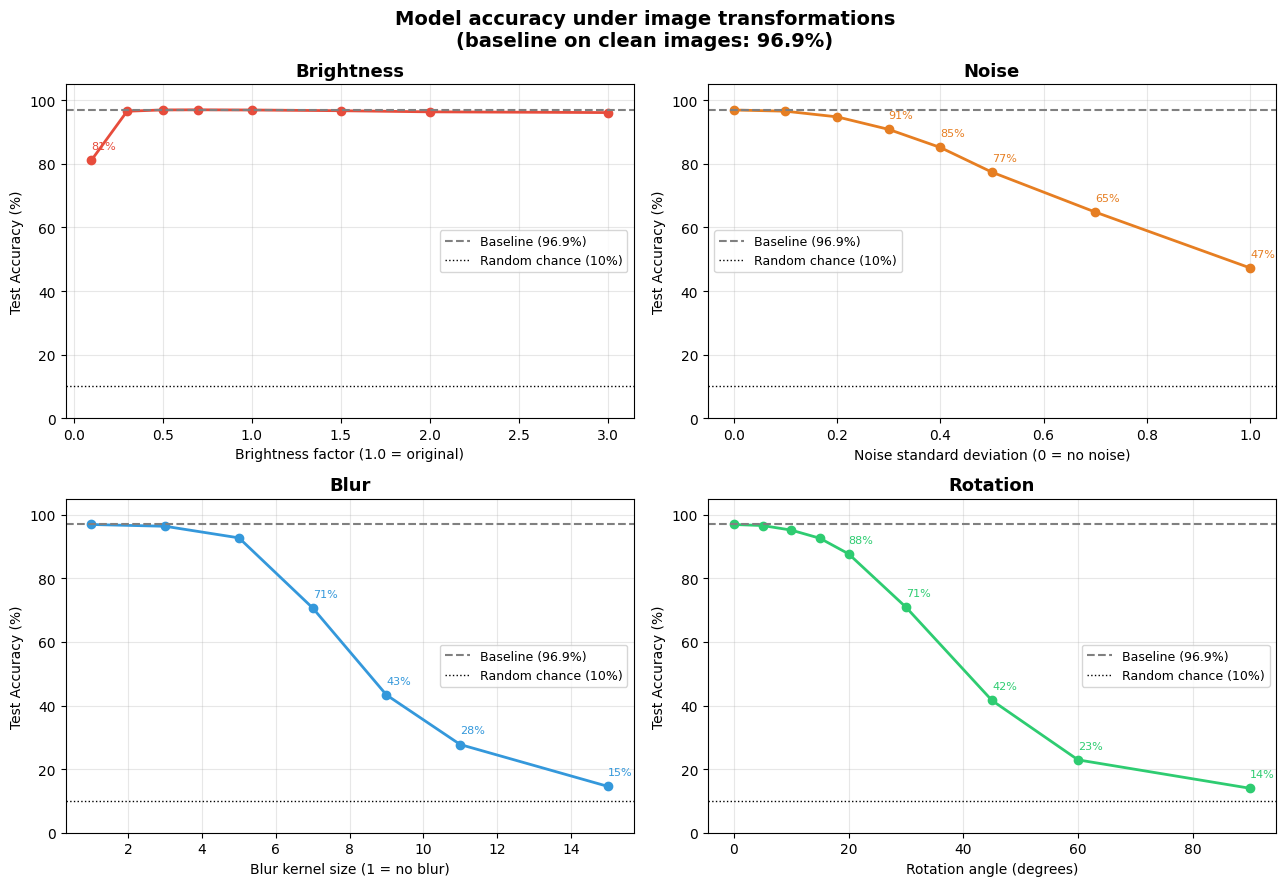

In [81]:
fig, axes = plt.subplots(2, 2, figsize=(13, 9))
fig.suptitle("Model accuracy under image transformations\n"
             f"(baseline on clean images: {clean_accuracy:.1f}%)",
             fontsize=14, fontweight='bold')

colors = ['#e74c3c', '#e67e22', '#3498db', '#2ecc71']
titles = ['Brightness', 'Noise', 'Blur', 'Rotation']
keys   = ['brightness', 'noise', 'blur', 'rotation']

for ax, key, color, title in zip(axes.flat, keys, colors, titles):
    r = results[key]
    ax.plot(r['x'], r['acc'], 'o-', color=color, linewidth=2, markersize=6)
    ax.axhline(y=clean_accuracy, color='gray', linestyle='--',
               linewidth=1.5, label=f"Baseline ({clean_accuracy:.1f}%)")
    ax.axhline(y=10, color='black', linestyle=':', linewidth=1,
               label="Random chance (10%)")
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel(r['xlabel'], fontsize=10)
    ax.set_ylabel("Test Accuracy (%)", fontsize=10)
    ax.set_ylim(0, 105)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # Annotate the baseline value on the line
    for xi, yi in zip(r['x'], r['acc']):
        if yi < clean_accuracy - 5:   # only annotate drops > 5%
            ax.annotate(f"{yi:.0f}%", (xi, yi),
                        textcoords="offset points", xytext=(0, 8),
                        fontsize=8, color=color)

plt.tight_layout()
plt.show()

### Summary Table

In [83]:
print("=" * 55)
print(f"{'Transformation':<20} {'Best':>8} {'Worst':>8} {'Drop':>8}")
print("=" * 55)

for key, title in zip(keys, titles):
    r      = results[key]
    best   = max(r['acc'])
    worst  = min(r['acc'])
    drop   = best - worst
    print(f"{title:<20} {best:>7.1f}%  {worst:>7.1f}%  {drop:>6.1f}%")

print("=" * 55)
print(f"{'Baseline (clean)':<20} {clean_accuracy:>7.1f}%")

Transformation           Best    Worst     Drop
Brightness              97.0%     81.2%    15.8%
Noise                   96.9%     47.3%    49.7%
Blur                    96.9%     14.6%    82.4%
Rotation                96.9%     14.0%    83.0%
Baseline (clean)        96.9%


### ✏️ Exercise 3 — What Does the Model Actually See?

Let's look at the images the model gets confused by. Pick one transformation and one strength level that caused a big accuracy drop. Visualise some examples where the model is **wrong**.

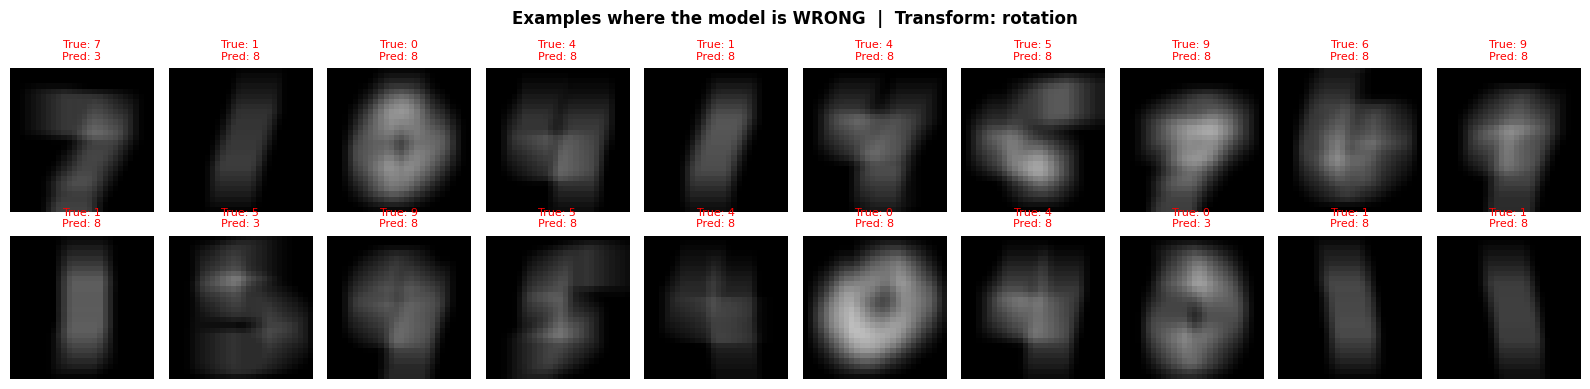

Showing 20 mistakes out of 20 found


In [90]:
# ── Experiment here ────────────────────────────────────────────────────────
# Change these to explore different failures:
TRANSFORM_NAME = "rotation"     # 'brightness', 'noise', 'blur', 'rotation'
TRANSFORM_FN   = lambda img: apply_blur(img, kernel_size=9)
# TRANSFORM_FN   = lambda img: apply_rotation(img, angle_degrees=30)

# ── Find mistakes ───────────────────────────────────────────────────────────
model.eval()
wrong_images, wrong_preds, wrong_true = [], [], []

with torch.no_grad():
    for imgs, labels in DataLoader(test_dataset, batch_size=256):
        imgs_np     = imgs.squeeze(1).numpy()
        transformed = np.stack([TRANSFORM_FN(img) for img in imgs_np])
        t           = torch.FloatTensor(transformed).unsqueeze(1).to(device)
        preds       = model(t).argmax(1).cpu()

        for i in range(len(labels)):
            if preds[i] != labels[i]:
                wrong_images.append(transformed[i])
                wrong_preds.append(preds[i].item())
                wrong_true.append(labels[i].item())
            if len(wrong_images) >= 20:
                break
        if len(wrong_images) >= 20:
            break

# ── Display ─────────────────────────────────────────────────────────────────
n_show = min(20, len(wrong_images))
fig, axes = plt.subplots(2, 10, figsize=(16, 4))
fig.suptitle(f"Examples where the model is WRONG  |  Transform: {TRANSFORM_NAME}",
             fontsize=12, fontweight='bold')

for i, ax in enumerate(axes.flat):
    if i < n_show:
        ax.imshow(wrong_images[i], cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"True: {wrong_true[i]}\nPred: {wrong_preds[i]}",
                     fontsize=8,
                     color='red' if wrong_true[i] != wrong_preds[i] else 'green')
    ax.axis('off')

plt.tight_layout()
plt.show()
print(f"Showing {n_show} mistakes out of {len(wrong_images)} found")

In [91]:
# get the numbers with most errors:
from collections import Counter
error_counts = Counter(wrong_true)
print("Digits with most errors:")
for digit, count in error_counts.most_common():
    print(f"  Digit {digit}: {count} errors")
    

Digits with most errors:
  Digit 1: 5 errors
  Digit 4: 4 errors
  Digit 0: 3 errors
  Digit 5: 3 errors
  Digit 9: 3 errors
  Digit 7: 1 errors
  Digit 6: 1 errors


### ✏️ Exercise 4 — Revisit Your Predictions

Go back to Exercise 2 and compare your predictions to the actual results.

Answer these questions in the cell below:

1. Were your predictions correct? What surprised you?
2. Which digit suffers most from rotation? Look at the gallery from Part 1 and think about why.
3. The model was trained on upright digits. What would you need to do so it handles rotated images correctly?
4. *(Bonus)* Can you think of a medical imaging scenario where this fragility would be dangerous?

In [ ]:
# Your reflections:

# 1. Were your predictions correct?
#    Yes

# 2. Which digit suffers most from rotation, and why?
#    1 and 4, because when blurred or rotated, they lose their distinctive features (the vertical line in "1" and the open top in "4")

# 3. What would you need to do to handle rotated images?
#    Identify the rotation and undo it or train the model on rotated images as well

# 4. (Bonus) A medical imaging scenario where this fragility is dangerous:
#    Identifying if a baby is on the placenta or not (rotated)


---
## Part 3 — A Glimpse of the Fix 💡

You have seen the problem. Now let's peek at a solution.

The idea is simple: if the model never saw rotated images during training, of course it fails on them. So — **train it on rotated images too**.

This is called **data augmentation**: artificially expanding your training set by showing the model transformed versions of images it already has.

Let's test whether it works.

In [92]:
# ── Train with augmentation ────────────────────────────────────────────────
augmented_transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),     # Random rotation ±30°
    transforms.RandomAffine(degrees=0,
                            translate=(0.1, 0.1)),  # Slight shift
    transforms.ToTensor(),
])

aug_train_dataset = datasets.MNIST(root='./data', train=True, download=True,
                                    transform=augmented_transform)
aug_train_loader  = DataLoader(aug_train_dataset, batch_size=64, shuffle=True)

# Fresh model with same architecture
model_aug     = SimpleNN().to(device)
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.001)

print("Training with rotation augmentation (3 epochs)...")
train(model_aug, aug_train_loader, criterion, optimizer_aug, epochs=3)

clean_aug = evaluate(model_aug, test_loader)
print(f"\n📊 Augmented model — accuracy on clean images: {clean_aug:.2f}%")
print(f"   Original model  — accuracy on clean images: {clean_accuracy:.2f}%")
print("\n(Small drop on clean images is normal — the model is now more general)")

Training with rotation augmentation (3 epochs)...


Epoch 1/3:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/3: 100%|██████████| 938/938 [00:03<00:00, 258.62it/s, acc=90.2%, loss=0.330]



✓ Training complete

📊 Augmented model — accuracy on clean images: 95.77%
   Original model  — accuracy on clean images: 96.93%

(Small drop on clean images is normal — the model is now more general)


In [93]:
# Compare both models on rotated images
print("Comparing original vs augmented model on rotated images:\n")
print(f"{'Angle':>8} | {'Original':>10} | {'Augmented':>10} | {'Improvement':>12}")
print("-" * 50)

for angle in [0, 10, 20, 30, 45, 60, 90]:
    fn  = lambda img, a=angle: apply_rotation(img, a)
    acc_orig = evaluate_with_transform(model,     test_dataset, fn)
    acc_aug  = evaluate_with_transform(model_aug, test_dataset, fn)
    diff     = acc_aug - acc_orig
    bar      = "▲" * max(0, int(diff / 3))
    print(f"{angle:>6}°  | {acc_orig:>9.1f}% | {acc_aug:>9.1f}% |"
          f" {diff:>+8.1f}%  {bar}")

Comparing original vs augmented model on rotated images:

   Angle |   Original |  Augmented |  Improvement
--------------------------------------------------
     0°  |      96.9% |      95.8% |     -1.2%  
    10°  |      95.2% |      95.3% |     +0.1%  
    20°  |      87.7% |      93.8% |     +6.1%  ▲▲
    30°  |      70.9% |      89.8% |    +18.8%  ▲▲▲▲▲▲
    45°  |      41.6% |      69.8% |    +28.2%  ▲▲▲▲▲▲▲▲▲
    60°  |      22.9% |      38.5% |    +15.6%  ▲▲▲▲▲
    90°  |      14.0% |      12.7% |     -1.3%  


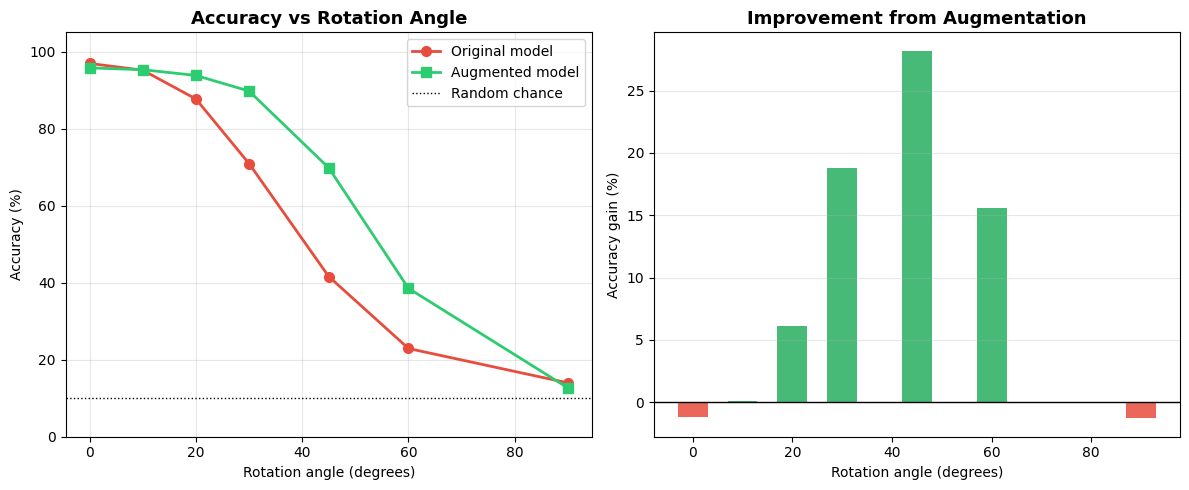

In [94]:
# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

angles_plot = [0, 10, 20, 30, 45, 60, 90]
acc_orig_list = [evaluate_with_transform(model,     test_dataset,
                                          lambda img, a=a: apply_rotation(img, a))
                 for a in angles_plot]
acc_aug_list  = [evaluate_with_transform(model_aug, test_dataset,
                                          lambda img, a=a: apply_rotation(img, a))
                 for a in angles_plot]

ax = axes[0]
ax.plot(angles_plot, acc_orig_list, 'o-', color='#e74c3c',
        linewidth=2, markersize=7, label='Original model')
ax.plot(angles_plot, acc_aug_list,  's-', color='#2ecc71',
        linewidth=2, markersize=7, label='Augmented model')
ax.axhline(y=10, color='black', linestyle=':', linewidth=1, label='Random chance')
ax.set_title("Accuracy vs Rotation Angle", fontsize=13, fontweight='bold')
ax.set_xlabel("Rotation angle (degrees)")
ax.set_ylabel("Accuracy (%)")
ax.set_ylim(0, 105)
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
improvements = [a - b for a, b in zip(acc_aug_list, acc_orig_list)]
colors_bar   = ['#27ae60' if x >= 0 else '#e74c3c' for x in improvements]
ax.bar(angles_plot, improvements, color=colors_bar, width=6, alpha=0.85)
ax.axhline(y=0, color='black', linewidth=1)
ax.set_title("Improvement from Augmentation", fontsize=13, fontweight='bold')
ax.set_xlabel("Rotation angle (degrees)")
ax.set_ylabel("Accuracy gain (%)")
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
## Wrapping Up 🎯

### What you discovered today

You started with a model achieving ~97% accuracy and found that:

- A **small rotation** (30°) can drop accuracy dramatically
- **Noise** degrades performance gradually but consistently
- **Brightness extremes** can almost completely fool the model
- **Training with augmentation** largely solves the rotation problem

### The deeper question

These transformations are *physically meaningful*:

| You applied | Next week, you will understand |
|-------------|-------------------------------|
| Brightness  | **Light and exposure** — how cameras collect photons |
| Noise       | **Sensor noise** — electronics in camera sensors |
| Blur        | **Optics** — lenses, focus, depth of field |
| Rotation    | **Viewpoint** — camera angle, object pose |

**Image formation is not just theory.** It directly explains why your model fails and what you need to do about it.

### ✏️ Exercise 5 — Final Reflection

Answer in the cell below:

1. Which result from today surprised you the most?
2. Name one real-world application where image variation (brightness, blur, rotation) is a major problem.
3. Data augmentation helped with rotation. Do you think it would also help with brightness changes? With blur? Why?

In [ ]:
# Final reflections:

# 1. What surprised you most?
#    The gains when training with augmented data

# 2. A real application where image variation is a major problem:
#    Idenfying car plates

# 3. Would augmentation help with brightness? With blur?
#    Brightness yes, because the main features remain strong, but a strong blurr changes the images too much to be recognizable, so only partialy.



---
## 📋 Submission Checklist

Before submitting this notebook, make sure:

- [ ] `adjust_brightness()`, `add_noise()`, `apply_rotation()` are implemented and working (Exercise 1)
- [ ] Exercise 2 predictions are written
- [ ] The full stress test ran (all four accuracy curves are plotted)
- [ ] You explored at least one failure case (Exercise 3)
- [ ] Exercises 4 and 5 are answered
- [ ] All cells have been executed in order

**Grading:**
- Implementation of transformation functions: Adequate
- Stress test results present: Adequate
- Exercises 2, 4, 5 answered thoughtfully: Above adequate
